In [ ]:
!pip3 install retentioneering

     |████████████████████████████████| 817 kB 8.6 MB/s 
     |████████████████████████████████| 1.3 MB 53.4 MB/s 
     |████████████████████████████████| 3.4 MB 55.1 MB/s 
     |████████████████████████████████| 9.8 MB 20.0 MB/s 
     |████████████████████████████████| 86 kB 3.7 MB/s 
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 51.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=93d79214b371d1de70fb0787edeadb11023d70042343ac0b5ae10dd5e96d1622
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=6faec9110d1a5899a6b3463fbdec7d725da74bead35f8673a9f3c939fa6f5023
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent
  Attempting uninstall:

In [ ]:
import retentioneering
import pandas as pd
import numpy as np
import io
from datetime import timedelta
import seaborn as sns

# Загрузка файла локально
для этого сохраните датасет в той же папке, в которой вы открываете ноутбук

In [ ]:
data = pd.read_csv('5.4_practice_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15792 entries, 0 to 15791
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          15792 non-null  int64 
 1   event_name       15792 non-null  object
 2   event_timestamp  15792 non-null  object
dtypes: int64(1), object(2)
memory usage: 370.2+ KB


# Загрузка файла при работе в google colab

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving 5.6_homework_dataset (1).csv to 5.6_homework_dataset (1).csv


In [ ]:
data = pd.read_csv(io.StringIO(uploaded['5.6_homework_dataset (1).csv'].decode('utf-8')),sep=',')

data['event_timestamp'] = pd.to_datetime(data['event_timestamp'])
data = data.sort_values('event_timestamp')
print(len(data))

4485197


# Подготовка данных

In [ ]:
user_id = 'user_pseudo_id'
event_name = 'event_name'
event_time = 'event_timestamp'
event_group = 'event_group'

data.shape

(4485197, 3)

In [ ]:
data[event_name].value_counts()

screen_view                       1166162
user_engagement                   1032663
phs_check_photo                    302889
phs_swipe_photo_full_size          144957
sys_click_back_button              140551
                                   ...   
basket_click_no_photo_alert            48
logout                                 41
os_notification_received               40
os_notification_opened                 34
os_notification_influence_open          5
Name: event_name, Length: 96, dtype: int64

In [ ]:
#обновление словаря retentioneering.config в соответствии с названиями колонок в нашем датафрейме
retentioneering.config.update({
    'event_col': event_name,
    'event_time_col': event_time,
    'user_col': user_id
})

In [ ]:
# удаляем ненужные префиксы
data[event_name] = data[event_name].apply(lambda x: x.split('sys')[0])
data[event_name] = data[event_name].apply(lambda x: x.split('os')[0])
data[event_name] = data[event_name].apply(lambda x: x.split('upload')[0])
data[event_name] = data[event_name].apply(lambda x: x.split('user_engagement')[0])
data[event_name] = data[event_name].apply(lambda x: x.split('screen_view')[0])

# выносим нужные префиксы в отдельный столбец
data[event_group] = data[event_name].apply(lambda x: x.split('_')[0])

# удаляем пустые значения
data[event_group].replace('', np.nan, inplace=True)
data.dropna(subset=[event_group], inplace=True)

#меняем название целевого события на 'passed'
data[event_group] = data[event_group].apply(lambda x: 'passed' if x=='chout' else x)

#смотрим что получилось
data[event_group].value_counts()

phs        699997
edit       247547
catalog    240157
tool       186337
preview    153457
onb         66232
basket      57142
reg         22092
first       19748
remove      13272
login        8890
passed       8667
logout         41
Name: event_group, dtype: int64

In [ ]:
#всем пользователям, которые не купили присваиваем значение lost
def add_lost_event(df):
    #список пользователей, у которых было событие покупки
    passed_ids = list(df[df[event_group]=='passed'][user_id])
    #отфильтруем все события с несконвертированными пользователсями
    lost_df = df[~df[user_id].isin(passed_ids)]
    #сгруппируем датасет по пользователям и возьмем последнее по времени событие, прибавим к нему 1 секунду
    lost_df = lost_df.groupby([user_id,'event_group'])[[event_time]].max().reset_index()
    
    #lost_df[event_time] = lost_df[event_time].apply(lambda x: x + timedelta(seconds=seconds_to_add))
    #переименуем событие в lost у всех строк
    lost_df[event_group] = 'lost'
    #склеим 2 датафрейма
    df_with_lost = pd.concat([df,lost_df])
    
    return df_with_lost

In [ ]:
#применяем функцию выше и получаем датафрейм
data_with_lost = add_lost_event(data)
data_with_lost

,event_timestamp,event_name,user_pseudo_id,event_group
899651,1970-01-18 22:54:22.926003000,remove,7be7da240172078b5d97b6b9942091f7,remove
1731663,1970-01-18 22:54:58.438523000,onb_auto_swipe,f3eb88ec2ef1e294a9014a1787b5678c,onb
1731664,1970-01-18 22:54:58.441970003,catalog_scroll_catalog,f3eb88ec2ef1e294a9014a1787b5678c,catalog
1731665,1970-01-18 22:54:58.443857005,catalog_scroll_catalog,f3eb88ec2ef1e294a9014a1787b5678c,catalog
1731666,1970-01-18 22:54:58.446096006,catalog_scroll_catalog,f3eb88ec2ef1e294a9014a1787b5678c,catalog
...,...,...,...,...
84256,1970-01-18 23:51:59.354776009,NaN,fffec865da328ec78360be318c905f1a,lost
84257,1970-01-18 23:53:17.005100013,NaN,fffec865da328ec78360be318c905f1a,lost
84258,1970-01-18 23:53:17.068082055,NaN,fffec865da328ec78360be318c905f1a,lost
84259,1970-01-18 23:51:59.410779017,NaN,fffec865da328ec78360be318c905f1a,lost


In [ ]:
df = data_with_lost [['user_pseudo_id', 'event_group', 'event_timestamp']]
df

,user_pseudo_id,event_group,event_timestamp
899651,7be7da240172078b5d97b6b9942091f7,remove,1970-01-18 22:54:22.926003000
1731663,f3eb88ec2ef1e294a9014a1787b5678c,onb,1970-01-18 22:54:58.438523000
1731664,f3eb88ec2ef1e294a9014a1787b5678c,catalog,1970-01-18 22:54:58.441970003
1731665,f3eb88ec2ef1e294a9014a1787b5678c,catalog,1970-01-18 22:54:58.443857005
1731666,f3eb88ec2ef1e294a9014a1787b5678c,catalog,1970-01-18 22:54:58.446096006
...,...,...,...
84256,fffec865da328ec78360be318c905f1a,lost,1970-01-18 23:51:59.354776009
84257,fffec865da328ec78360be318c905f1a,lost,1970-01-18 23:53:17.005100013
84258,fffec865da328ec78360be318c905f1a,lost,1970-01-18 23:53:17.068082055
84259,fffec865da328ec78360be318c905f1a,lost,1970-01-18 23:51:59.410779017


In [ ]:
#обновление словаря retentioneering.config в соответствии с названиями колонок в нашем датафрейме
retentioneering.config.update({
    'event_col': event_group,
    'event_time_col': event_time,
    'user_col': user_id
})

In [ ]:
#смотрим траекторию пользователя с min количеством операций (13)
single_user_trajectory = df[df.user_pseudo_id	== 'b87836fb7f199e8cc136d0f5e787da2c']
single_user_trajectory 

,user_pseudo_id,event_group,event_timestamp
1302606,b87836fb7f199e8cc136d0f5e787da2c,first,1970-01-18 23:28:54.735055000
1302607,b87836fb7f199e8cc136d0f5e787da2c,onb,1970-01-18 23:28:54.736001003
1302608,b87836fb7f199e8cc136d0f5e787da2c,onb,1970-01-18 23:28:54.738886006
1302609,b87836fb7f199e8cc136d0f5e787da2c,catalog,1970-01-18 23:28:54.741596008
1302610,b87836fb7f199e8cc136d0f5e787da2c,catalog,1970-01-18 23:28:54.747403002
1302611,b87836fb7f199e8cc136d0f5e787da2c,remove,1970-01-18 23:28:54.761767010
60368,b87836fb7f199e8cc136d0f5e787da2c,lost,1970-01-18 23:28:54.747403002
60369,b87836fb7f199e8cc136d0f5e787da2c,lost,1970-01-18 23:28:54.735055000
60370,b87836fb7f199e8cc136d0f5e787da2c,lost,1970-01-18 23:28:54.738886006
60371,b87836fb7f199e8cc136d0f5e787da2c,lost,1970-01-18 23:28:54.761767010


In [ ]:
#смотрим траекторию пользователя с максимальным количеством операций
single_user_trajectory = df[df.user_pseudo_id	== '022bfc74210aeba5ca8861c6872afb9a']
single_user_trajectory

,user_pseudo_id,event_group,event_timestamp
10414,022bfc74210aeba5ca8861c6872afb9a,catalog,1970-01-18 22:57:21.261116002
10415,022bfc74210aeba5ca8861c6872afb9a,catalog,1970-01-18 22:57:21.263254005
10416,022bfc74210aeba5ca8861c6872afb9a,catalog,1970-01-18 22:57:21.267638008
10417,022bfc74210aeba5ca8861c6872afb9a,tool,1970-01-18 22:57:21.492535003
10418,022bfc74210aeba5ca8861c6872afb9a,tool,1970-01-18 22:57:21.492938004
...,...,...,...
20295,022bfc74210aeba5ca8861c6872afb9a,preview,1970-01-18 23:54:53.502773620
20296,022bfc74210aeba5ca8861c6872afb9a,preview,1970-01-18 23:54:53.503059623
20297,022bfc74210aeba5ca8861c6872afb9a,edit,1970-01-18 23:54:53.511184626
20298,022bfc74210aeba5ca8861c6872afb9a,preview,1970-01-18 23:54:53.524639627


# Граф

Посмотрим расположение событий в виде графа

Проверяем, что все события присутствуют, корректно отображаются. 

Однако, сделать вывод о проблемном месте по данной картине затруднительно

In [ ]:
data_with_lost.rete.plot_graph(
                     #weight_col='client_id',# None(default), 'event_group' e.g.'client_id'
                     norm_type='full',#'full'(default), None(absolute values), 'node'
                     targets={'passed':'green',
                                'lost':'red'
                               },
                     thresh=0.01,
                    );

Какие переходы между событиями есть в наших данных:


In [ ]:
edgelist = data_with_lost.rete.get_edgelist(weight_col='user_pseudo_id', norm_type=None, edge_attributes='users_nunique')
edgelist.sort_values('users_nunique', ascending=False).head(10)

,event_group,next_event_group,users_nunique
64,onb,onb,17054
34,first,lost,16778
12,catalog,catalog,16573
16,catalog,lost,14276
63,onb,lost,14273
54,lost,onb,14199
102,remove,lost,12032
50,lost,catalog,11566
117,tool,tool,10347
110,tool,lost,10229


Видно, что максимальное количество уников ходит в петле онбординга, также большинство уников уходят в lost с первого экрана и с онбординга

Построим матрицу переходов пользователей между событиями (матрицу связности)

In [ ]:
df = data_with_lost.rete.get_adjacency(weight_col='user_pseudo_id', norm_type=None)

def rotateheader():
    return  [
     dict(selector="th", props=[("font-size", "75%"),
                            ("text-align", "right")
                          ]),
        dict(selector="th.col_heading", props=[("font-size", "75%"),
                            ("text-align", "left"),
                            ("transform", "translate(0%,-30%) rotate(-10deg)")
                          ]),
             dict(selector="caption", props=[("caption-side", "bottom")])
                ]

cm = sns.light_palette("green", as_cmap=True)
print("\n\n\n")
df.style.background_gradient(cmap=cm).set_table_styles(rotateheader()).set_caption(" .")

,basket,catalog,edit,login,lost,passed,phs,preview,reg,remove,tool,first,onb,logout
basket,3659.000000,2513.000000,931.000000,43.000000,2876.000000,3088.000000,84.000000,853.000000,19.000000,339.000000,2953.000000,0.000000,0.000000,0.000000
catalog,182.000000,16573.000000,36.000000,927.000000,14276.000000,18.000000,4900.000000,7.000000,2945.000000,135.000000,6001.000000,1.000000,1308.000000,0.000000
edit,1347.000000,452.000000,2853.000000,0.000000,1001.000000,0.000000,1851.000000,1865.000000,0.000000,12.000000,1105.000000,0.000000,0.000000,0.000000
login,13.000000,31.000000,0.000000,7.000000,5735.000000,8.000000,3.000000,0.000000,0.000000,0.000000,3043.000000,0.000000,0.000000,1.000000
lost,1158.000000,11566.000000,547.000000,3172.000000,0.000000,0.000000,1949.000000,648.000000,453.000000,9345.000000,8343.000000,0.000000,14199.000000,8.000000
passed,2109.000000,427.000000,239.000000,0.000000,0.000000,0.000000,57.000000,128.000000,0.000000,439.000000,1463.000000,0.000000,1.000000,2.000000
phs,2095.000000,1889.000000,2108.000000,1.000000,3268.000000,238.000000,6534.000000,1768.000000,0.000000,35.000000,2168.000000,0.000000,1.000000,0.000000
preview,1128.000000,294.000000,2103.000000,0.000000,902.000000,0.000000,8.000000,2407.000000,0.000000,13.000000,758.000000,0.000000,0.000000,0.000000
reg,0.000000,160.000000,0.000000,1765.000000,2859.000000,0.000000,0.000000,0.000000,4473.000000,0.000000,159.000000,0.000000,0.000000,0.000000
remove,0.000000,0.000000,0.000000,0.000000,12032.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,1.000000,3.000000,0.000000


По матрице видно:
1. Максимальный объем транзакций происходит в онбординге.
2. Много переходов в passed осуществляются из basket (3088), phs (238) и tool (275). 
3. В lost уходят в основном с первого экрана, с каталога, с онбординга и из инструментов. 

Отнормируем матрицу на число уникальных пользователей


In [ ]:
df = data_with_lost.rete.get_adjacency(weight_col='user_pseudo_id', norm_type='full')

cm = sns.light_palette("green", as_cmap=True)
print("\n\n\n")
df.style.background_gradient(cmap=cm).set_table_styles(rotateheader()).set_caption(" .")

,basket,catalog,edit,login,lost,passed,phs,preview,reg,remove,tool,first,onb,logout
basket,0.140202,0.096291,0.035673,0.001648,0.110200,0.118323,0.003219,0.032684,0.000728,0.012990,0.113150,0.000000,0.000000,0.000000
catalog,0.006974,0.635030,0.001379,0.035520,0.547015,0.000690,0.187754,0.000268,0.112844,0.005173,0.229941,0.000038,0.050119,0.000000
edit,0.051613,0.017319,0.109319,0.000000,0.038355,0.000000,0.070925,0.071461,0.000000,0.000460,0.042340,0.000000,0.000000,0.000000
login,0.000498,0.001188,0.000000,0.000268,0.219749,0.000307,0.000115,0.000000,0.000000,0.000000,0.116599,0.000000,0.000000,0.000038
lost,0.044371,0.443176,0.020959,0.121542,0.000000,0.000000,0.074680,0.024829,0.017358,0.358073,0.319680,0.000000,0.544065,0.000307
passed,0.080811,0.016361,0.009158,0.000000,0.000000,0.000000,0.002184,0.004905,0.000000,0.016821,0.056058,0.000000,0.000038,0.000077
phs,0.080274,0.072381,0.080772,0.000038,0.125220,0.009119,0.250364,0.067745,0.000000,0.001341,0.083071,0.000000,0.000038,0.000000
preview,0.043222,0.011265,0.080581,0.000000,0.034562,0.000000,0.000307,0.092229,0.000000,0.000498,0.029044,0.000000,0.000000,0.000000
reg,0.000000,0.006131,0.000000,0.067630,0.109549,0.000000,0.000000,0.000000,0.171392,0.000000,0.006092,0.000000,0.000000,0.000000
remove,0.000000,0.000000,0.000000,0.000000,0.461031,0.000000,0.000000,0.000000,0.000000,0.001111,0.000000,0.000038,0.000115,0.000000


В матрице уникальных пользователей видим:
1. В lost уходит 64% пользователей с первого экрана, и 54% с онбординга, вероятно есть какие-то проблемы с загрузкой приложения и с введением пользовательских данных.
2. 11% пользователей совершают целевое действие из корзины, при этом в корзину переходят 17% пользователей из инструментов, видимо приобретаются какие-то доп.инструменты для работы с фото.

# Кластеризация

Сделаем кластеризацию и оценим, на какие кластеры распадаются наши данные по конверсии

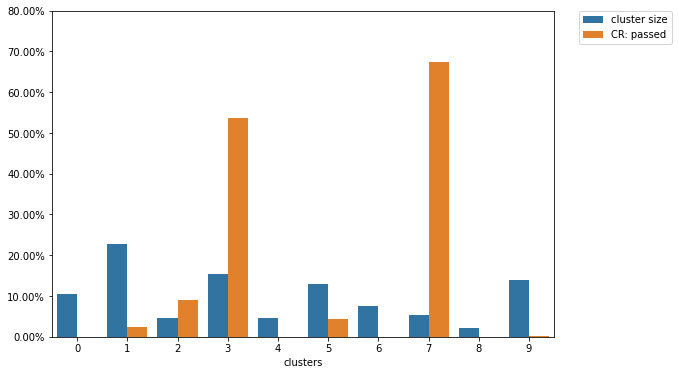

In [ ]:
data_with_lost.rete.get_clusters(plot_type='cluster_bar', 
                       n_clusters=10,
                       refit_clusters = True, 
                       ngram_range=(1,2),
                       targets=['passed']
                      );

Кластеры с максимальной конверсией - 7, 3 и 2.
С маленькой конверсией - 5, 1 и 9.
С нулевой конверсией - 0, 4, 6, 8.

Построим TSNE проекцию пользователей из TF-IDF пространства:

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



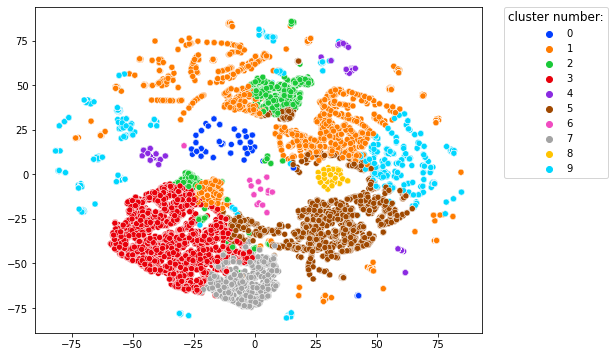

In [ ]:
data_with_lost.rete.project(method='tsne', plot_type='clusters');

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



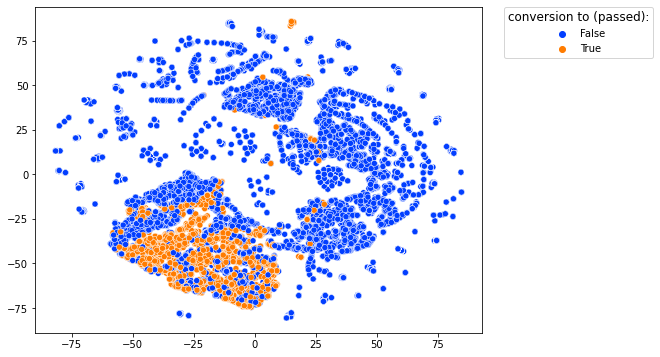

In [ ]:
data_with_lost.rete.project(method='tsne', 
                  plot_type='targets',
                  targets=['passed']);

Построим граф для нескольких кластеров

In [ ]:
#самый конверсионный кластер - 7
data_with_lost.rete.filter_cluster(7).rete.plot_graph(
                     norm_type='full',
                     targets={'passed':'green',
                              'lost':'red'
                               },
                     thresh=0.003,
                    );

Пользователи 7 кластера активно работают с фото, редактируют их, делают предпросмотр, реже используют редактор материалов.

In [ ]:
#3 кластер тоже с высокой конверсией
data_with_lost.rete.filter_cluster(3).rete.plot_graph(
                     norm_type='full',
                     targets={'passed':'green',
                              'lost':'red'
                               },
                     thresh=0.003,
                    );

Пользователи 3го кластера в основном работают с фото, все остальные функции используют в меньшем объеме

In [ ]:
#5 кластер с низкой конверсией
data_with_lost.rete.filter_cluster(5).rete.plot_graph(
                     norm_type='full',
                     targets={'passed':'green',
                                'lost':'red'
                               },
                     thresh=0.003,
                    );

Пользователи 5го кластера чаще используют редактор материалов, реже взаимодействуют с каталогом, редактируют фото, работают в каталоге. 
Значительная часть пользователей уходят в lost с первого экрана и онбординга.

In [ ]:
#1 кластер тоже с низкой конверсией
data_with_lost.rete.filter_cluster(1).rete.plot_graph(
                     norm_type='full',
                     targets={'passed':'green',
                                'lost':'red'
                               },
                     thresh=0.003,
                    );

Пользователи 1 кластера в основном работают в каталоге. Значительная часть пользователей уходят в lost с первого экрана и онбординга.

In [ ]:
# один из худших по конверсии - 4
data_with_lost.rete.filter_cluster(4).rete.plot_graph(
                     norm_type='full',
                     targets={'passed':'green',
                                'lost':'red'
                               },
                     thresh=0.001,
                    );

Пользователи 4го кластера в большинстве случаев уходят с первого экрана и с онбординга. Учитывая что на онбординге большая петля - явно есть какая-то проблема на этом этапе.

In [ ]:
# один из худших по конверсии - 8
data_with_lost.rete.filter_cluster(8).rete.plot_graph(
                     norm_type='full',
                     targets={'passed':'green',
                                'lost':'red'
                               },
                     thresh=0.003,
                    );

Пользователи 8го кластера с первого экрана уходят в потерю, вероятно есть проблемы с первым экраном

Исследуем профиль 7 кластера - какие события и как часто вызывались его пользователями

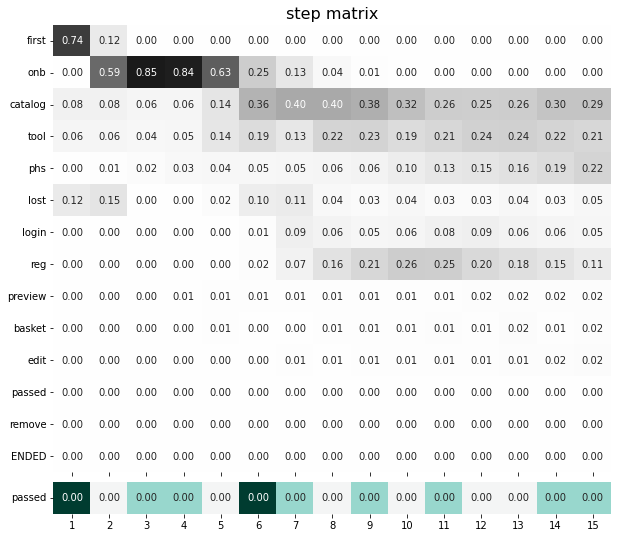

In [ ]:
step_matrix_3 = data_with_lost.rete.filter_cluster(7).rete.step_matrix(max_steps=15,
                                  targets=['passed'])

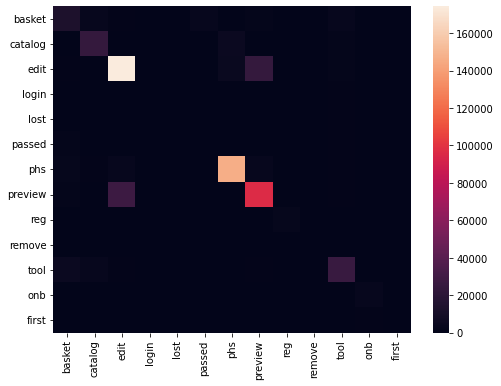

In [ ]:
sns.heatmap(data_with_lost.rete.filter_cluster(7).rete.get_adjacency());

Более детальное рассмотрение Топ-10 событий кластера и сравнение со всеми пользователями всех кластеров

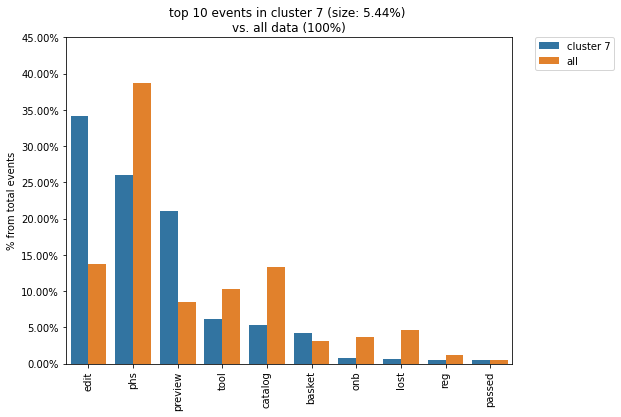

In [ ]:
data_with_lost.rete.cluster_event_dist(7, top_n=10)

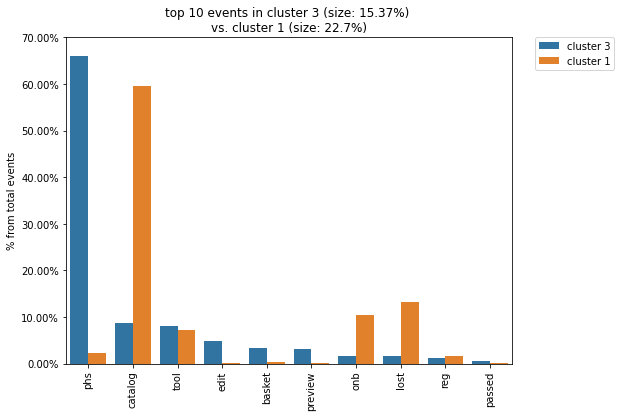

In [ ]:
#сравниваем самый конверсионный кластер (3) с самым большим кластером (1)
data_with_lost.rete.cluster_event_dist(3,1, top_n=10)

1 кластер приобладает в онбординге, вероятно там сосредоточены новые клиенты. 3 кластер чаще работает с фото, а 1 кластер чаще смотрит каталоги.

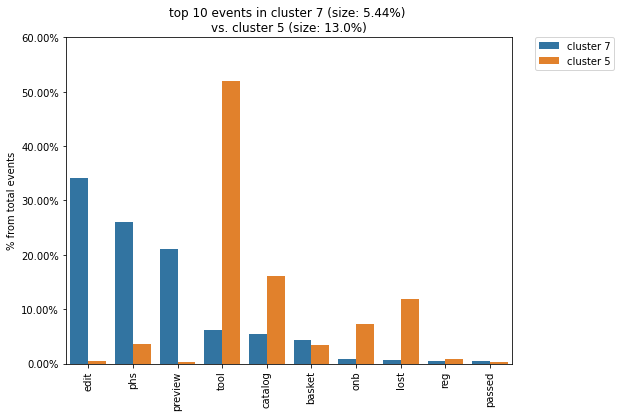

In [ ]:
#сравним 7 (лучшая конверсия) и 5 (конверсия слабая) кластер
data_with_lost.rete.cluster_event_dist(7,5, top_n=10)

Опять же видно, что в 5ом кластере приобладает онбординг. 
7 кластер больше вовлечен в функции (работа с фото, редактирование, просмотр), кластер 5 в основном занимается редактированием материалов.

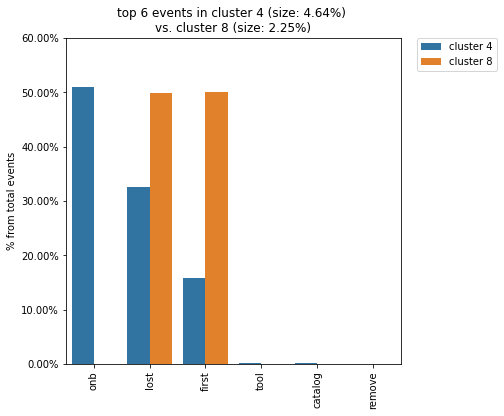

In [ ]:
#смотрим на нулевые кластеры - 4 и 8  
data_with_lost.rete.cluster_event_dist(4,8, top_n=10)

Видно, что пользователи слетели с первого экрана и онбординга, вероятно есть какие-то проблемы на этих этапах

**Выводы**

В представленных данных условно я бы выделил 3 макро-сегмента: 1 макро-сегмент с высокой конверсией (сегмент 3 и 7), 2ой - максимальный сегмент по количеству пользователей и с низкой конверсией (2, 5, 1 и 9) и 3ий - с нулевой конверсией (4, 6, 8).

1 макросегмент отличается от остальных повышенной вовлеченностью в использование продукта (работа с фото, редактирование, предпросмотр), что положительно влияет на конверсию.

2 макросегмент характеризуется низкой вовлеченностью, в основном это пользователи которые смотрят катологи и работают с редактором материалов, значительная часть этих пользователей новые.

3 макросегмент - пользователи, которые вылетают с первого экрана и которые не могут пройти онбординг. Вероятнее всего это связано с неустойчивость приложения, а также с сложностями при регистрации.


Расширим N-граммы длины 1 до N-грамм длины 2: учтём переходы

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



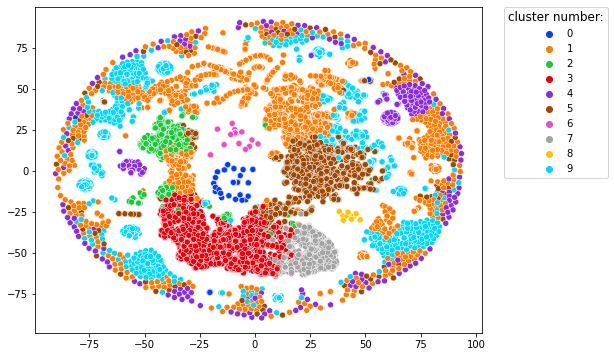

In [ ]:
data_with_lost.rete.project(plot_type='clusters', ngram_range=(1, 2));

Сколько у нас уникальных событий:

In [ ]:
data['event_group'].nunique()

13

Сколько уникальных переходов:

In [ ]:
edgelist = data.rete.get_edgelist()
edgelist.shape[0]

102

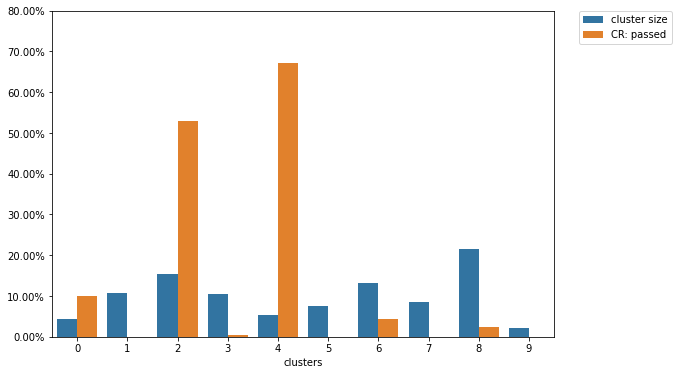

In [ ]:
data.rete.get_clusters(n_clusters=10,
                       plot_type='cluster_bar',
                       targets=['passed'],
                       ngram_range=(1, 2));

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



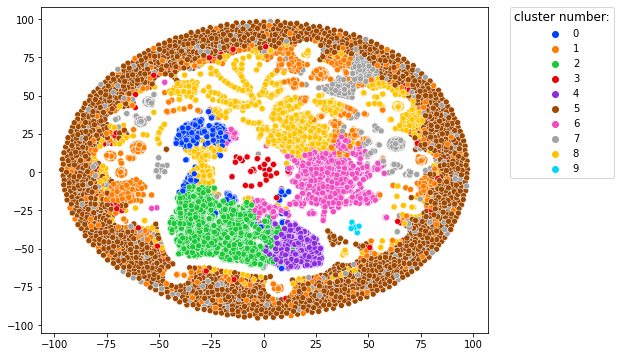

In [ ]:
data.rete.project(plot_type='clusters', ngram_range=(1, 2));